In [1]:
import sys
import numpy as np
sys.path.append('../')
from model import data_preparation as prep

# Get Some Data

In [ ]:
con = prep.create_connection()
prepared_data = prep.prepare_data(con,20)

In [3]:
prepared_data

{483: {'abahn': False,
  'brand': 'oil!',
  'bstr': True,
  'county': '13075',
  'sstr': False,
  'state': 'mecklenburg-vorpommern',
  'time_series': {'test': array([1289, 1289, 1289, ..., 1299, 1429, 1429]),
   'train': array([1369, 1369, 1369, ..., 1289, 1289, 1289])}},
 1292: {'abahn': True,
  'brand': 'shell',
  'bstr': True,
  'county': '03359',
  'sstr': False,
  'state': 'niedersachsen',
  'time_series': {'test': array([1339, 1339, 1329, ..., 1309, 1489, 1489]),
   'train': array([1399, 1399, 1399, ..., 1379, 1359, 1339])}},
 2227: {'abahn': False,
  'brand': 'raiffeisen',
  'bstr': False,
  'county': '15081',
  'sstr': False,
  'state': 'sachsen-anhalt',
  'time_series': {'test': array([1349, 1349, 1349, ..., 1349, 1349, 1349]),
   'train': array([1269, 1269, 1269, ..., 1349, 1349, 1349])}},
 2481: {'abahn': False,
  'brand': 'raiffeisen',
  'bstr': True,
  'county': '03251',
  'sstr': False,
  'state': 'niedersachsen',
  'time_series': {'test': array([1304, 1304, 1304, ..., 13

# Remove Trend
## with np.log

In [4]:
for key in prepared_data:
    prepared_data[key]["time_series"]["test"] = np.log(prepared_data[key]["time_series"]["test"].reshape(-1,1))
    prepared_data[key]["time_series"]["train"] = np.log(prepared_data[key]["time_series"]["train"].reshape(-1,1))
    

# using partial autocorelation

In [5]:
from statsmodels.tsa.stattools import pacf

keys = list(prepared_data.keys())

x_pacf=pacf( prepared_data[keys[0]]['time_series']['train'] , nlags =10, method='ols')

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
x_pacf # tells us one time lag correlates the most with 0.9

array([ 1.        ,  0.93428397, -0.02261486, -0.09392683, -0.05500249,
       -0.07190439, -0.06033599, -0.06388201,  0.32648963,  0.02157718,
        0.06901596])

# Encode States numerical

In [7]:
def encodeState(data):
    states = {
     'baden-württemberg':1,
     'bayern':2,
     'berlin':3,
     'brandenburg':4,
     'bremen':5,
     'hamburg':6,
     'hessen':7,
     'mecklenburg-vorpommern':8,
     'niedersachsen':9,
     'nordrhein-westfalen':10,
     'rheinland-pfalz':11,
     'saarland':12,
     'sachsen':13,
     'sachsen-anhalt':14,
     'schleswig-holstein':15,
     'thüringen':16
    }
    data["state"] = states[data["state"]]
    return data

# Arrange Data to have List of training instances

In [8]:
x_train_adjusted = {}
x_test_adjusted = {}
y_train_adjusted = {}
y_test_adjusted = {}
for k in keys:
    prepared_data[k] = encodeState(prepared_data[k])
    x_train = prepared_data[k]["time_series"]["train"][0:-2]
    y_train_adjusted[k] = prepared_data[k]["time_series"]["train"][1:-1]
    x_test = prepared_data[k]["time_series"]["test"][0:-2]
    y_test_adjusted[k] = prepared_data[k]["time_series"]["test"][1:-1]
    x_train_adjusted[k] = []
    x_test_adjusted[k] = []
    for p in x_train:
        features = []
        features.append(np.float(p[0]))
        features.append(prepared_data[k]["state"])
        features.append(k)
        features.append(hash(prepared_data[k]["brand"]))
        features.append(prepared_data[k]["county"])
        features.append(int(prepared_data[k]["abahn"]))
        features.append(int(prepared_data[k]["bstr"]))
        features.append(int(prepared_data[k]["sstr"]))
        x_train_adjusted[k].append(features)
    x_test_adjusted[k] = []
    for p in x_test:
        features = []
        features.append(np.float(p[0]))
        features.append(k)
        features.append(hash(prepared_data[k]["brand"]))
        features.append(prepared_data[k]["state"])
        features.append(prepared_data[k]["county"])
        features.append(int(prepared_data[k]["abahn"]))
        features.append(int(prepared_data[k]["bstr"]))
        features.append(int(prepared_data[k]["sstr"]))
        x_test_adjusted[k].append(features)

In [9]:
x_train_adjusted =np.array([x_train_adjusted[k] for k in sorted(x_train_adjusted.keys())])
x_train_adjusted = x_train_adjusted.reshape(-1,8)
x_test_adjusted =np.array([x_test_adjusted[k] for k in sorted(x_test_adjusted.keys())])
x_test_adjusted = x_test_adjusted.reshape(-1,8)
y_test_adjusted =np.array([y_test_adjusted[k] for k in sorted(y_test_adjusted.keys())])
y_test_adjusted = y_test_adjusted.reshape(-1,1)
y_train_adjusted =np.array([y_train_adjusted[k] for k in sorted(y_train_adjusted.keys())])
y_train_adjusted = y_train_adjusted.reshape(-1,1)


# normalize price MinMax

In [10]:
maxValue =y_train_adjusted[:,0].max()
x_train_adjusted = x_train_adjusted.astype(float)
x_test_adjusted = x_test_adjusted.astype(float)
x_train_adjusted[:,0] *=1/maxValue
x_test_adjusted[:,0] *=1/maxValue
y_test_adjusted[:,0] *=1/maxValue
y_train_adjusted[:,0] *=1/maxValue

In [11]:
x_train_adjusted[0]

array([  9.57253170e-01,   8.00000000e+00,   4.83000000e+02,
         7.32669783e+18,   1.30750000e+04,   0.00000000e+00,
         1.00000000e+00,   0.00000000e+00])

In [12]:
x_train_adjusted = np.array(x_train_adjusted)
x_test_adjusted = np.array(x_test_adjusted)
#x_train_adjusted = x_train_adjusted.reshape(x_train_adjusted.shape + (1, ))
#x_test_adjusted = x_test_adjusted.reshape(x_test_adjusted.shape + (1, ))

# fitting lasso regression model

seems to fit best our problem with a penalty value of 1e^-6

0.895596358471


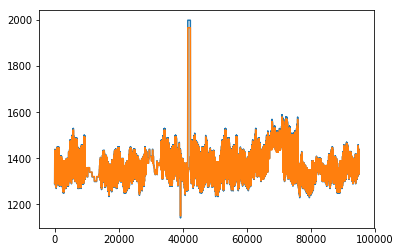

In [13]:
from sklearn import linear_model
import matplotlib.pyplot as plt
clf = linear_model.LassoLars(0.0000001)
clf.fit (x_train_adjusted, y_train_adjusted)
print(clf.score(x_test_adjusted , y_test_adjusted))

plt.plot(np.exp(y_test_adjusted*maxValue))
plt.plot(np.exp(clf.predict(x_test_adjusted)*maxValue))
plt.show()

In [14]:
x_test_adjusted

array([[  9.49271838e-01,   4.83000000e+02,   7.32669783e+18, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  9.49271838e-01,   4.83000000e+02,   7.32669783e+18, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  9.49271838e-01,   4.83000000e+02,   7.32669783e+18, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       ..., 
       [  9.57253170e-01,   1.51820000e+04,  -5.16458179e+18, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  9.57253170e-01,   1.51820000e+04,  -5.16458179e+18, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  9.57253170e-01,   1.51820000e+04,  -5.16458179e+18, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00]])

In [17]:

from sklearn.metrics import mean_squared_error
mean_squared_error(np.exp(y_test_adjusted*maxValue), np.exp(clf.predict(x_test_adjusted*maxValue)))

104109.39975801193